In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

In [14]:
def generate_line_patterns(num_patterns, height, width, line_probability):
    patterns = np.zeros((num_patterns, height, width)) # create a height*width matrix for each pattern

    # create lines with equal & independent probability
    for pattern_index in range(num_patterns):
        for i in range(height):
            if np.random.uniform(0,1) <= line_probability:
                patterns[pattern_index, i, :] = 1

        for j in range(width):
            if np.random.uniform(0,1) <= line_probability:
                patterns[pattern_index, :, j] = 1
    
    # flatten height*width matrix to vector
    #print(patterns)
    patterns = np.reshape(patterns, (num_patterns, height*width))
    return patterns

In [15]:
def sigmoid_func(delta, u):
    return 1/(1+np.exp(-delta*u))

def transient(X,Q,Y,W,T, delta, nr_of_iterations, y_step):
    # Calculates change in Y values for all inputs simultanously
    # Use nr_of_iterations and y_step to scale

    Y_data = np.zeros((Y.shape[0], X.shape[0])) # nr of neurons x nr of data points
    qx = np.dot(Q,X.T)

    for _ in range(nr_of_iterations):
        wy = np.dot(W,Y_data)
        dydt = sigmoid_func(delta, qx+wy-T) - Y_data
        Y_data += y_step*dydt
    
    # Round all Y values to 0 or 1
    output = np.zeros((Y_data.shape[0], Y_data.shape[1]))
    output[Y_data > 0.5] = 1
    return output

def update_connections(X,Q,Y,W,T, alpha, beta, gamma, p):
    # use the mean value for all data in Y (16x100, so 100 data points)
    # Q= 16 X 64
    # X= 100 x 64
    # Y= 16 x 100
    # T= 16 x 1
    # W= 16 x 16

    # threshold
    T += np.reshape(gamma*np.mean(Y-p, axis=1),T.shape)

    # hebbian rule
    yx = np.dot(Y,X) / X.shape[0] # mean over all data points
    yq = Q * np.reshape(np.mean(Y, axis=1),(Q.shape[0],1)) # multiply 64 columns of Q with 16x1 vector of Y mean
    Q += beta*(yx - yq)

    # anti hebbian rule
    mask = np.ones((W.shape[0], W.shape[1]))
    mask[np.diag_indices_from(mask)] = 0 # set all w with i=j to 0
    mask[W > 0] = 0 # set all w>0 to 0
    yiyj = np.dot(Y,Y.T)/Y.shape[1] # mean of product over all data points
    W -= alpha*(yiyj - p**2)
    W = W*mask

    return T,Q,W

def display(Q):
    # taken from https://github.com/derekwan1/sparse-bars
    fig, ax = plt.subplots(nrows=4, ncols=4)
    r = 0
    for row in ax:
        c = 0
        for col in row:
            col.imshow(np.reshape(Q.T[:, (r * 4) + c], (8, 8)), cmap="gray")
            c += 1
        r += 1
    plt.show()
    

Initialized Thresholds
Trial 0


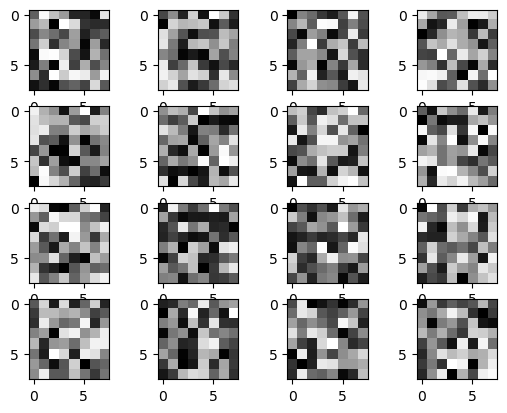

Trial 200


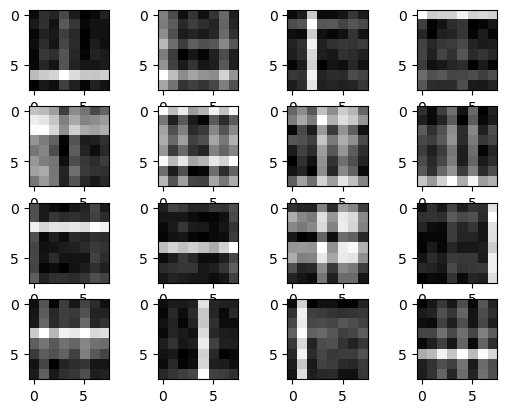

Trial 400


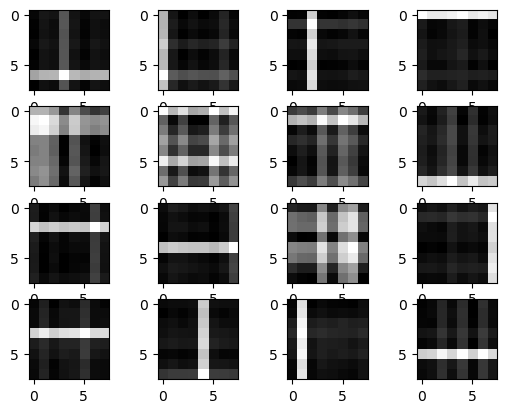

Trial 600


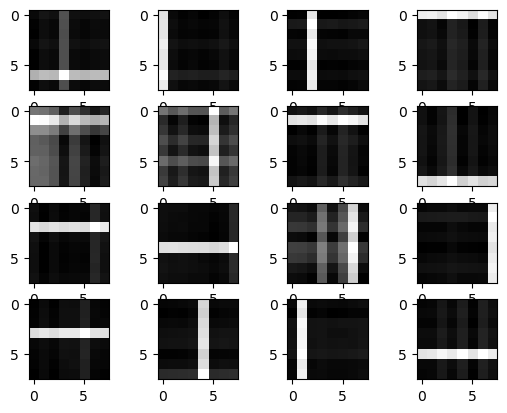

Trial 800


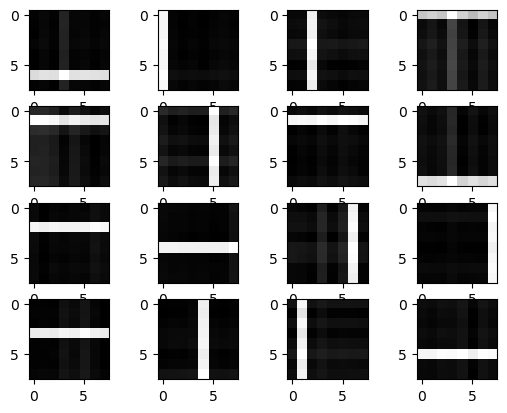

Trial 1000


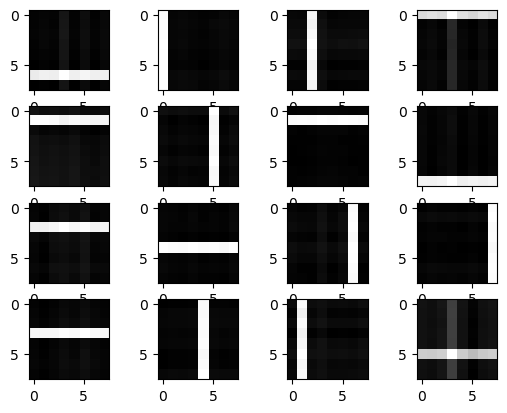

Trial 1199


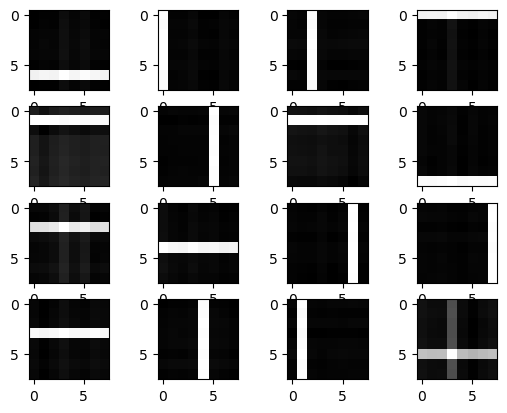

In [16]:
np.random.seed(42)

## Parameters
m = 64 # 8*8 input pixels
n = 16 # 16 neurons
data_points_per_trial = 100

alpha = 0.1
beta = 0.02
gamma = 0.02
delta = 10
p = 0.125

initial_threshold_trials = 100
learning_trials = 1200
transient_iterations = 100
y_step = 0.01

## Network matrices
# input
X = np.array((data_points_per_trial, m))

# feedforward weights
Q = np.random.uniform(0,1,(n,m)) 
Q = np.array([normalize([Q[i]], norm="l2")[0] for i in range(n)]) # normalize the weight vector for each neuron to the unit length

# output
Y = np.zeros((n,1))

# feedback weights
W = np.zeros((n,n))

# thresholds
T = np.ones((n,1))

alpha = 0
beta = 0
gamma = 0.1
X = generate_line_patterns(100,8,8,p)
#X = generate_line_patterns(100, 8, 8, p)
for i in range(initial_threshold_trials):
    Y = transient(X,Q,Y,W,T,delta,transient_iterations,y_step)
    T,Q,W = update_connections(X,Q,Y,W,T,alpha,beta,gamma,p)

print("Initialized Thresholds")



alpha = 0.1
beta = 0.04
gamma = 0.04
for i in range(learning_trials):
    if i % 200 == 0:
        print(f"Trial {i}")
        display(Q)
    X = generate_line_patterns(100, 8, 8, p)
    Y = transient(X,Q,Y,W,T,delta,transient_iterations,y_step)
    T,Q,W = update_connections(X,Q,Y,W,T,alpha,beta,gamma,p)

print(f"Trial {i}")
display(Q)
